In [ ]:
import pandas as pd


# Loading the dataset
df = pd.read_csv("forestCover.csv")
print(df.shape)
df.head()

(581012, 59)


,Elevation,Aspect,Facet,Slope,Inclination,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,...,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Water_Level,Observation_ID,Cover_Type
0,3208920,166,415.394727,6,0.691628,408,62,3137,225,242,...,0,0,0,0,0,0,0,2,1,2
1,2789020,137,343.302186,9,0.621245,30,2,1040,235,237,...,0,0,0,0,0,0,0,3,1,3
2,3384615,357,894.231390,9,-0.266086,362,15,3113,207,225,...,0,0,0,0,0,0,0,4,1,1
3,3348150,148,371.346939,6,0.786375,247,50,1207,228,240,...,0,0,0,0,0,0,0,5,1,2
4,3061955,124,310.783430,11,-0.335685,170,19,1595,238,232,...,0,0,0,0,0,0,0,6,1,2


In [ ]:
# Dropping both Observation_ID (identifier) and Water_Level (constant)
df.drop(columns=['Observation_ID', 'Water_Level'], inplace=True)

In [ ]:
#highly correlated to Aspect so dropping it also
df.drop(columns=['Facet'], inplace=True)

In [ ]:
# just contains noisy data so must be dropped
df.drop(columns=['Inclination'], inplace=True)

In [11]:
# fixing the issue of soil type not being binary 0 and 1
df['Soil_Type1'] = df['Soil_Type1'].map({'positive': 1, 'negative': 0}).astype(int)


In [ ]:
# fixing missing values issue (only Slope has missing values)
df = df.replace('?', pd.NA)

df = df.apply(pd.to_numeric, errors='ignore')

# Imputing slope with median
df['Slope'] = df['Slope'].fillna(df['Slope'].median())


/tmp/ipykernel_29185/1351378673.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [ ]:
from sklearn.preprocessing import RobustScaler

# scaling to fix the outliers issue and the range differences issue
num_features = [
    'Elevation',
    'Aspect',
    'Slope',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Horizontal_Distance_To_Fire_Points',
    'Hillshade_9am',
    'Hillshade_Noon',
    'Hillshade_3pm'
]

scaler = RobustScaler()
df[num_features] = scaler.fit_transform(df[num_features])
df.head()


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,-0.259887,0.193069,-0.777778,0.688406,0.516129,0.513051,0.212121,0.666667,0.163265,0.429882,...,0,0,0,0,0,0,0,0,0,2
1,-1.333333,0.049505,-0.444444,-0.681159,-0.451613,-0.430693,0.515152,0.458333,-0.204082,0.061599,...,0,0,0,0,0,0,0,0,0,3
2,0.189266,1.138614,-0.444444,0.521739,-0.241935,0.502250,-0.333333,-0.041667,0.265306,-0.927261,...,0,0,0,0,0,0,0,0,0,1
3,0.096045,0.103960,-0.777778,0.105072,0.322581,-0.355536,0.303030,0.583333,0.040816,0.455439,...,0,0,0,0,0,0,0,0,0,2
4,-0.635593,-0.014851,-0.222222,-0.173913,-0.177419,-0.180918,0.606061,0.250000,-0.387755,0.738532,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
from typing import Counter
from imblearn.under_sampling import TomekLinks

# fixing imbalance in cover type
X = df.drop(columns=['Cover_Type'])
y = df['Cover_Type']
print("Original class distribution:", Counter(y))
# Apply Tomek links undersampling
tomek = TomekLinks(sampling_strategy='majority')
X_resampled, y_resampled = tomek.fit_resample(X, y)

print("After Tomek links:", Counter(y_resampled))

Original class distribution: Counter({2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747})
After Tomek links: Counter({2: 277093, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747})


In [ ]:

# baseline model for kNN
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier

# the full dataset
X_full = df.drop(columns=['Cover_Type'])
y_full = df['Cover_Type']

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, 
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

# Sampling 10% of training data 
X_train_sample = X_train.sample(frac=0.2, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

print(f"Baseline evaluation on {X_train_sample.shape[0]} samples")

knn_baseline = KNeighborsClassifier(n_neighbors=5)

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(knn_baseline, X_train_sample, y_train_sample, cv=cv, scoring='accuracy')

print(f"Baseline kNN Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Baseline evaluation on 92962 samples
Baseline kNN Accuracy: 0.8565 ± 0.0024


Full training: 464809 samples
Sampled training: 92962 samples
Test set: 116203 samples
Running k-NN Grid Search with 5-fold CV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END metric=minkowski, n_neighbors=3, p=2, weights=uniform; total time=  12.3s
[CV] END metric=minkowski, n_neighbors=3, p=2, weights=uniform; total time=  12.3s
[CV] END metric=minkowski, n_neighbors=3, p=2, weights=uniform; total time=  12.9s
[CV] END metric=minkowski, n_neighbors=3, p=2, weights=uniform; total time=  12.7s
[CV] END metric=minkowski, n_neighbors=3, p=2, weights=uniform; total time=  12.1s
[CV] END metric=minkowski, n_neighbors=3, p=2, weights=distance; total time=  12.3s
[CV] END metric=minkowski, n_neighbors=3, p=2, weights=distance; total time=  12.0s
[CV] END metric=minkowski, n_neighbors=3, p=2, weights=distance; total time=  12.1s
[CV] END metric=minkowski, n_neighbors=3, p=2, weights=distance; total time=  12.1s
[CV] END metric=minkowski, n_neighbors=3, p=2, weights=dis

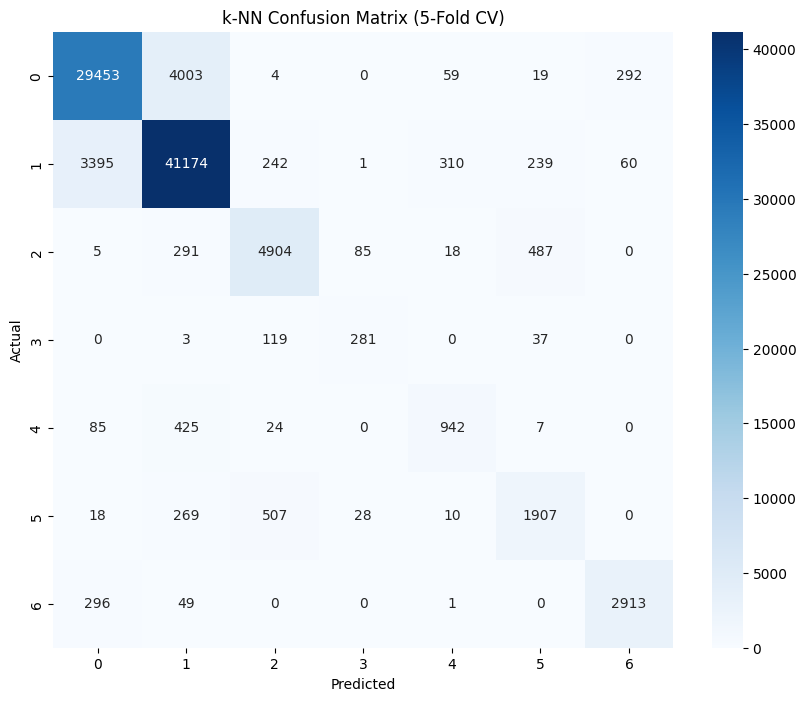


Confusion Matrix:
[[29453  4003     4     0    59    19   292]
 [ 3395 41174   242     1   310   239    60]
 [    5   291  4904    85    18   487     0]
 [    0     3   119   281     0    37     0]
 [   85   425    24     0   942     7     0]
 [   18   269   507    28    10  1907     0]
 [  296    49     0     0     1     0  2913]]

Held-out Test Set Accuracy: 0.8886


In [ ]:
#stopppppppppp
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# the full dataset
X_full = df.drop(columns=['Cover_Type'])
y_full = df['Cover_Type']

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, 
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

# Sampling 10% of training data
X_train_sample = X_train.sample(frac=0.2, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

print(f"Full training: {X_train.shape[0]} samples")
print(f"Sampled training: {X_train_sample.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# jhe parameter grid for kNN
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

# Grid search on sampled training data ....
print("Running k-NN Grid Search with 5-fold CV...")
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train_sample, y_train_sample)
print("Best Params:", grid_search.best_params_)

# Getting training and test scores
best_index = grid_search.best_index_
train_score = grid_search.cv_results_['mean_train_score'][best_index]
test_score = grid_search.best_score_

print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy (CV): {test_score:.4f}")

# Getting the best model
best_knn = grid_search.best_estimator_

# Cross-validation scores with mean and std
cv_scores = cross_val_score(best_knn, X_train_sample, y_train_sample, cv=cv, scoring='accuracy')
print(f"\n5-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Individual fold scores: {cv_scores}")

# F1 scores
f1_scores = cross_val_score(best_knn, X_train_sample, y_train_sample, cv=cv, scoring='f1_macro')
print(f"5-Fold CV F1-Macro: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

# Getting the  predictions for confusion matrix
y_pred_cv = cross_val_predict(best_knn, X_train_sample, y_train_sample, cv=cv)

# Detailed results
print("\nClassification Report (5-fold CV):")
print(classification_report(y_train_sample, y_pred_cv))

macro_f1 = f1_score(y_train_sample, y_pred_cv, average='macro')
weighted_f1 = f1_score(y_train_sample, y_pred_cv, average='weighted')
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_train_sample, y_pred_cv)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('k-NN Confusion Matrix (5-Fold CV)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nConfusion Matrix:")
print(cm)

# Testing on held-out test set to see how good is generalization
test_pred = best_knn.predict(X_test)
test_accuracy = best_knn.score(X_test, y_test)
print(f"\nHeld-out Test Set Accuracy: {test_accuracy:.4f}")